# Project Objective: Fake vs. Real Text Detection in Space Research Documents

This project aims to develop an AI system to differentiate real from fake texts in a dataset from The Messenger journal, where each pair contains one authentic and one LLM-modified document. The challenge is to detect subtle manipulations, including hallucinations or factual changes, without access to the original text. The goal is to build a robust algorithm that generalizes across varied modifications, addressing AI security risks such as data poisoning and overreliance on automated text generation. This approach ensures reliable identification of authentic documents, supporting data integrity in space-related operations.

## 1. Loading Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install kaggle
from google.colab import files
files.upload()   # upload kaggle.json here (API token from Kaggle account)
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c fake-or-real-the-impostor-hunt
!unzip fake-or-real-the-impostor-hunt.zip -d /content/fake-or-real

Saving fake-or-real-the-impostor-hunt.zip to fake-or-real-the-impostor-hunt.zip
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Archive:  fake-or-real-the-impostor-hunt.zip
  inflating: /content/fake-or-real/data/test/article_0000/file_1.txt  
  inflating: /content/fake-or-real/data/test/article_0000/file_2.txt  
  inflating: /conten

In [6]:
# ----------------- Train Loader -----------------
def load_train_data(train_dir, csv_path):
    df_gt = pd.read_csv(csv_path)   # ground truth (id + real_text_id)
    records = []

    for _, row in df_gt.iterrows():
        folder_id = row['id']
        real_text_id = row['real_text_id']

        folder_path = os.path.join(train_dir, f"article_{folder_id:04d}")
        try:
            with open(os.path.join(folder_path, "file_1.txt"), encoding="utf-8") as f1:
                text1 = f1.read().strip()
            with open(os.path.join(folder_path, "file_2.txt"), encoding="utf-8") as f2:
                text2 = f2.read().strip()
        except FileNotFoundError as e:
            print(f"Skipping article {folder_id}: {e}")
            continue

        # Assign label (1 if file_1 is real, else 0)
        is_file1_real = 1 if real_text_id == 1 else 0

        records.append({
            "id": folder_id,
            "text1": text1,
            "text2": text2,
            "is_file1_real": is_file1_real
        })

    return pd.DataFrame(records)


# ----------------- Test Loader -----------------
def load_test_data(test_dir):
    records = []

    for folder in sorted(os.listdir(test_dir)):
        if folder.startswith("article_"):
            folder_id = int(folder.split('_')[1])
            folder_path = os.path.join(test_dir, folder)
            try:
                with open(os.path.join(folder_path, "file_1.txt"), encoding="utf-8") as f1:
                    text1 = f1.read().strip()
                with open(os.path.join(folder_path, "file_2.txt"), encoding="utf-8") as f2:
                    text2 = f2.read().strip()
            except FileNotFoundError as e:
                print(f"Skipping article {folder_id}: {e}")
                continue

            records.append({
                "id": folder_id,
                "text1": text1,
                "text2": text2
            })

    return pd.DataFrame(records)


# ----------------- Paths -----------------
train_path = "/content/fake-or-real/data/train"
test_path  = "/content/fake-or-real/data/test"
train_csv  = "/content/fake-or-real/data/train.csv"

# ----------------- Load Data -----------------
df_train = load_train_data(train_path, train_csv)
df_test  = load_test_data(test_path)

# ----------------- Save to Drive -----------------
#df_train.to_csv("/content/drive/MyDrive/Kaggle/fake-or-real-the-impostor-hunt/df_train.csv", index=False)
#df_test.to_csv("/content/drive/MyDrive/Kaggle/fake-or-real-the-impostor-hunt/df_test.csv", index=False)

print("✅ DataFrames saved:")
print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)


✅ DataFrames saved:
df_train shape: (95, 4)
df_test shape: (1068, 3)


## 2. Data Preprocessing

In [7]:
df_train.head()

,id,text1,text2,is_file1_real
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,0
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,0
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,0


In [8]:
df_train.shape

(95, 4)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             95 non-null     int64 
 1   text1          95 non-null     object
 2   text2          95 non-null     object
 3   is_file1_real  95 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 3.1+ KB


In [10]:
df_train.isna().sum()

,0
id,0
text1,0
text2,0
is_file1_real,0


In [11]:
df_train.dropna(inplace=True)

In [12]:
df_train.isna().sum()

,0
id,0
text1,0
text2,0
is_file1_real,0


In [13]:
df_test.head()

,id,text1,text2
0,0,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...
1,1,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...
2,2,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...
3,3,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor..."
4,4,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...


In [14]:
df_test.shape

(1068, 3)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1068 non-null   int64 
 1   text1   1068 non-null   object
 2   text2   1068 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.2+ KB


In [ ]:
df_test.isna().sum()

,0
id,0
text1,0
text2,0


In [ ]:
df_test.dropna(inplace=True)

In [ ]:
df_test.isna().sum()

,0
id,0
text1,0
text2,0


In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.6 MB/s eta 0:00:00


## 3. Exploratory Data Analysis

In [ ]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from wordcloud import WordCloud
import textstat

from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Load your dataset
df = df_train.copy()  # assuming you already have df_train loaded

# For plotting style
#sns.set(style="whitegrid", palette="pastel")

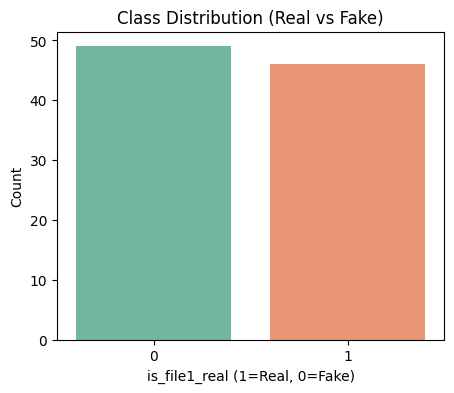

In [ ]:
# 1. Class Distribution
plt.figure(figsize=(5,4))
sns.countplot(x="is_file1_real", data=df, palette="Set2")
plt.title("Class Distribution (Real vs Fake)")
plt.xlabel("is_file1_real (1=Real, 0=Fake)")
plt.ylabel("Count")
plt.show()

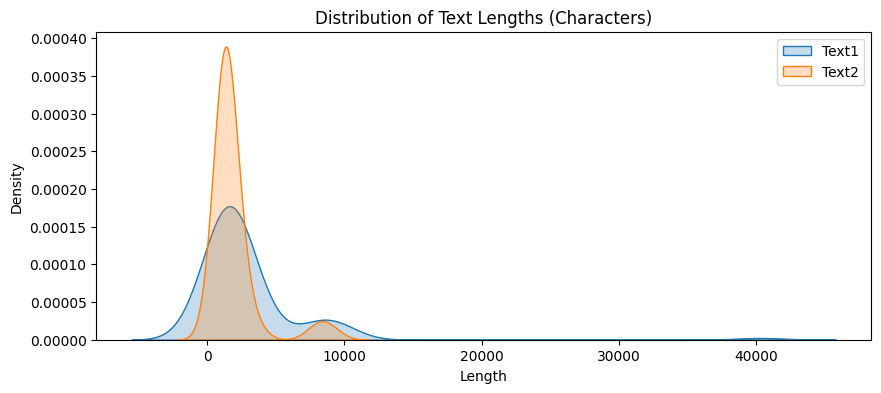

In [ ]:
# 2. Text Length Distribution (Characters & Tokens)
df["len_text1"] = df["text1"].str.len()
df["len_text2"] = df["text2"].str.len()

plt.figure(figsize=(10,4))
sns.kdeplot(df["len_text1"], label="Text1", fill=True)
sns.kdeplot(df["len_text2"], label="Text2", fill=True)
plt.title("Distribution of Text Lengths (Characters)")
plt.xlabel("Length")
plt.legend()
plt.show()

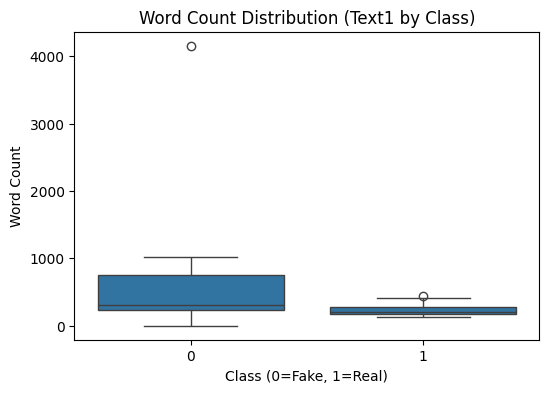

In [ ]:
# 3. Average Word Count by Class
df["wc_text1"] = df["text1"].apply(lambda x: len(str(x).split()))
df["wc_text2"] = df["text2"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.boxplot(x="is_file1_real", y="wc_text1", data=df)
plt.title("Word Count Distribution (Text1 by Class)")
plt.xlabel("Class (0=Fake, 1=Real)")
plt.ylabel("Word Count")
plt.show()

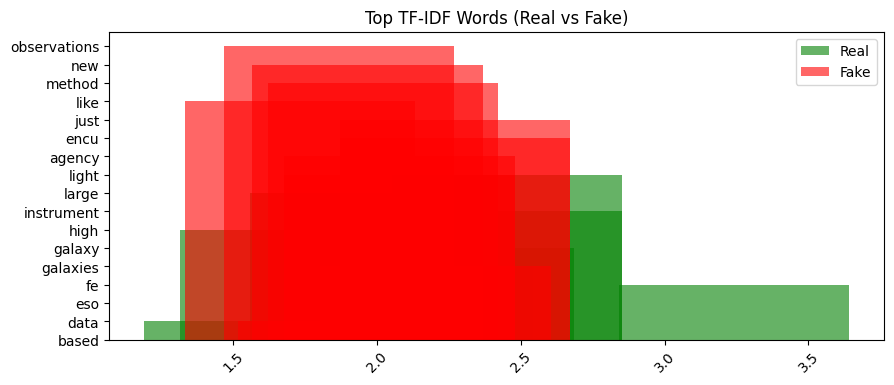

In [ ]:
# 4. Top Frequent Words (TF-IDF Barplot)

tfidf = TfidfVectorizer(stop_words="english", max_features=20)
X = tfidf.fit_transform(df.loc[df["is_file1_real"]==1, "text1"])
top_words_real = pd.Series(tfidf.get_feature_names_out(), index=tfidf.idf_).sort_values().head(10)

X = tfidf.fit_transform(df.loc[df["is_file1_real"]==0, "text1"])
top_words_fake = pd.Series(tfidf.get_feature_names_out(), index=tfidf.idf_).sort_values().head(10)

plt.figure(figsize=(10,4))
plt.bar(top_words_real.index, top_words_real.values, color="green", alpha=0.6, label="Real")
plt.bar(top_words_fake.index, top_words_fake.values, color="red", alpha=0.6, label="Fake")
plt.title("Top TF-IDF Words (Real vs Fake)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

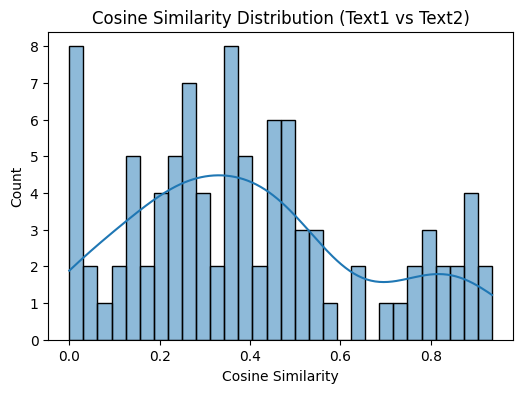

In [ ]:
# 5. Word Overlap / Cosine Similarity between text1 and text2
tfidf = TfidfVectorizer(stop_words="english")
vecs = tfidf.fit_transform(pd.concat([df["text1"], df["text2"]]))

n = len(df)
sim_scores = []
for i in range(n):
    v1 = vecs[i]
    v2 = vecs[i+n]
    sim = cosine_similarity(v1, v2)[0][0]
    sim_scores.append(sim)

df["similarity"] = sim_scores

plt.figure(figsize=(6,4))
sns.histplot(df["similarity"], kde=True, bins=30)
plt.title("Cosine Similarity Distribution (Text1 vs Text2)")
plt.xlabel("Cosine Similarity")
plt.show()


In [ ]:
df.head()

,id,text1,text2,is_file1_real,len_text1,len_text2,wc_text1,wc_text2,similarity
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1,2196,2018,304,296,0.189302
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,0,3124,936,454,137,0.188366
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1,1139,801,159,125,0.060594
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,0,1774,1869,263,262,0.125313
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,0,195,871,34,123,0.000000


Many text pairs have low similarity (0.1–0.4) → they are quite different.

A smaller number have high similarity (0.7–0.9) → these are likely paraphrases or near-duplicates.

The distribution suggests your dataset has a mix of related and unrelated text pairs.

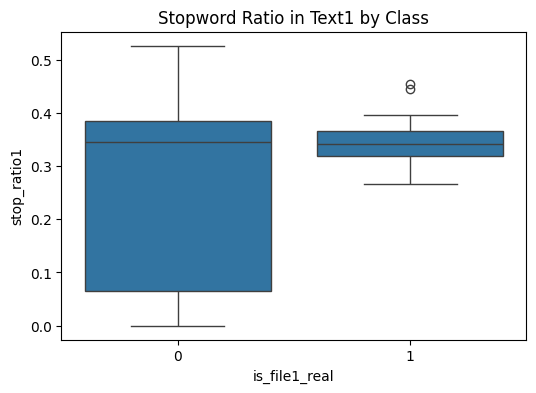

In [ ]:
# 6. Stopword Ratio
nlp = spacy.load("en_core_web_sm")

def stopword_ratio(text):
    doc = nlp(str(text))
    stop = sum(1 for token in doc if token.is_stop)
    return stop / max(1,len(doc))

df["stop_ratio1"] = df["text1"].apply(stopword_ratio)
df["stop_ratio2"] = df["text2"].apply(stopword_ratio)

plt.figure(figsize=(6,4))
sns.boxplot(x="is_file1_real", y="stop_ratio1", data=df)
plt.title("Stopword Ratio in Text1 by Class")
plt.show()

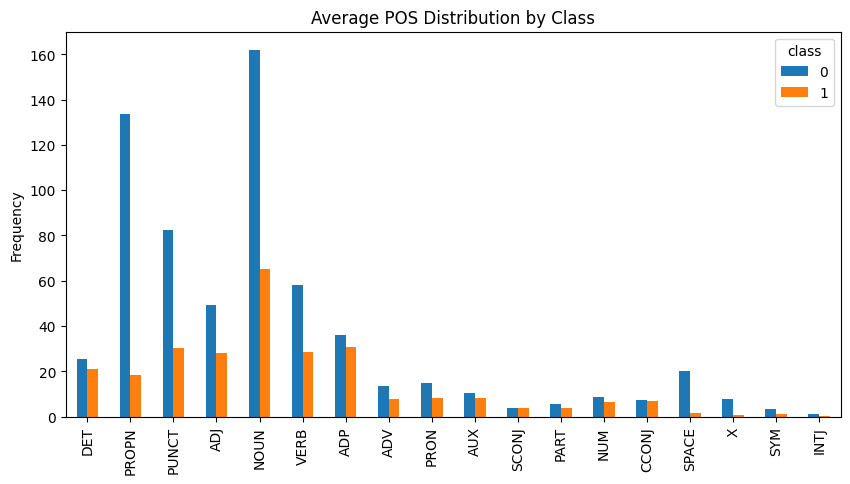

In [ ]:
# 7. POS Tag Distribution
def pos_counts(text):
    doc = nlp(str(text))
    counts = Counter([token.pos_ for token in doc])
    return counts

pos_data = df["text1"].apply(pos_counts)
pos_df = pd.DataFrame(pos_data.tolist()).fillna(0)
pos_df["class"] = df["is_file1_real"]

avg_pos = pos_df.groupby("class").mean().T

avg_pos.plot(kind="bar", figsize=(10,5))
plt.title("Average POS Distribution by Class")
plt.ylabel("Frequency")
plt.show()

X-axis → POS tags (DET, PROPN, NOUN, VERB, etc.). Each represents a grammatical category (e.g.

DET = Determiner (the, a, this)

PROPN = Proper Noun (John, India)

NOUN = Noun (car, idea)

VERB = Verb (run, eat, is)

ADJ = Adjective (big, smart)

ADV = Adverb (quickly, very)

Y-axis → Frequency (average count of words belonging to each POS tag).

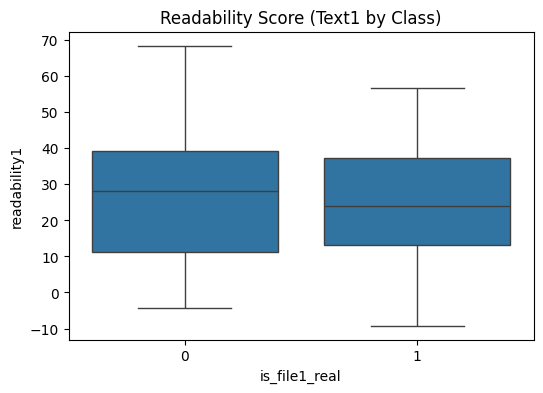

In [ ]:
# 8. Readability Scores
df["readability1"] = df["text1"].apply(lambda x: textstat.flesch_reading_ease(str(x)))
plt.figure(figsize=(6,4))
sns.boxplot(x="is_file1_real", y="readability1", data=df)
plt.title("Readability Score (Text1 by Class)")
plt.show()

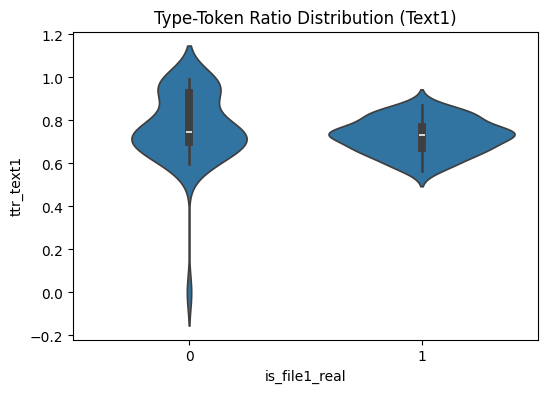

In [ ]:
# 9. Vocabulary Richness (Type-Token Ratio)
def type_token_ratio(text):
    words = str(text).split()
    return len(set(words)) / max(1,len(words))

df["ttr_text1"] = df["text1"].apply(type_token_ratio)

plt.figure(figsize=(6,4))
sns.violinplot(x="is_file1_real", y="ttr_text1", data=df)
plt.title("Type-Token Ratio Distribution (Text1)")
plt.show()

Type-Token Ratio (TTR) = unique words ÷ total words in a text. [It measures lexical diversity.]

High TTR → more varied vocabulary (many unique words).

Low TTR → more repetition, less variety.

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

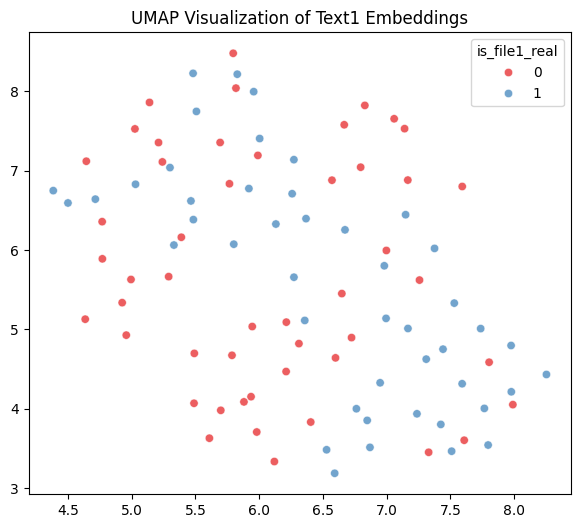

In [ ]:
# 10. Embedding Visualization (UMAP / t-SNE)
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings1 = model.encode(df["text1"].tolist(), show_progress_bar=True)

# Dimensionality reduction
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
reduced = reducer.fit_transform(embeddings1)

plt.figure(figsize=(7,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=df["is_file1_real"], palette="Set1", alpha=0.7)
plt.title("UMAP Visualization of Text1 Embeddings")
plt.show()

In [ ]:
df.head()

,id,text1,text2,is_file1_real,len_text1,len_text2,wc_text1,wc_text2,similarity,stop_ratio1,stop_ratio2,readability1,ttr_text1
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1,2196,2018,304,296,0.189302,0.285714,0.359133,-2.916056,0.819079
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,0,3124,936,454,137,0.188366,0.400786,0.305732,-2.859140,0.709251
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1,1139,801,159,125,0.060594,0.360465,0.377778,0.219231,0.830189
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,0,1774,1869,263,262,0.125313,0.340694,0.334559,23.320625,0.752852
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,0,195,871,34,123,0.000000,0.526316,0.278571,68.431667,0.911765


## 4. Data Cleaning

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# NLTK Setup
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def cleaning(text):
    if pd.isna(text):
        return ""

    # 1. Remove HTML
    text = BeautifulSoup(text, 'html.parser').get_text()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 3. Keep only alphanumeric + whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 4. Lowercase
    text = text.lower()

    # 5. Tokenize using regex
    words = re.findall(r'\b\w+\b', text)

    # 6. Remove stopwords + Lemmatize
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 1]

    # 7. Join back into string
    return ' '.join(words)

#  Apply Cleaning in df_train
df['text1_clean'] = df['text1'].apply(cleaning)
df['text2_clean'] = df['text2'].apply(cleaning)

#  Apply Cleaning in df_test
df_test['text1_clean'] = df_test['text1'].apply(cleaning)
df_test['text2_clean'] = df_test['text2'].apply(cleaning)

#  Optional: Check Cleaned Samples
print(df[['text1_clean', 'text2_clean']].head())
print(df_test[['text1_clean', 'text2_clean']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                         text1_clean  \
0  virsa visible infrared survey telescope array ...   
1  china goal project involves achieving accuracy...   
2  scientist learn galaxy form evolve two method ...   
3  china study suggests multiple star system play...   
4  dinosaur rex excited new toy set many dinosaur...   

                                         text2_clean  
0  china relay network released significant amoun...  
1  project aim achieve accuracy level 005 dex ana...  
2  dinosaur eggshell offer clue dinosaur ate long...  
3  importance understanding star evolve led resea...  
4  analyzing fast star rotate within galaxy compa...  
                                         text1_clean  \
0  music music music music music music music musi...   
1  underground exploration sn birth provided valu...   
2  research aimed understand star shape differ pe...   
3  using omegacams wide field capability spanning...   
4  assemblyculture assemblyculture assemblycultur... 

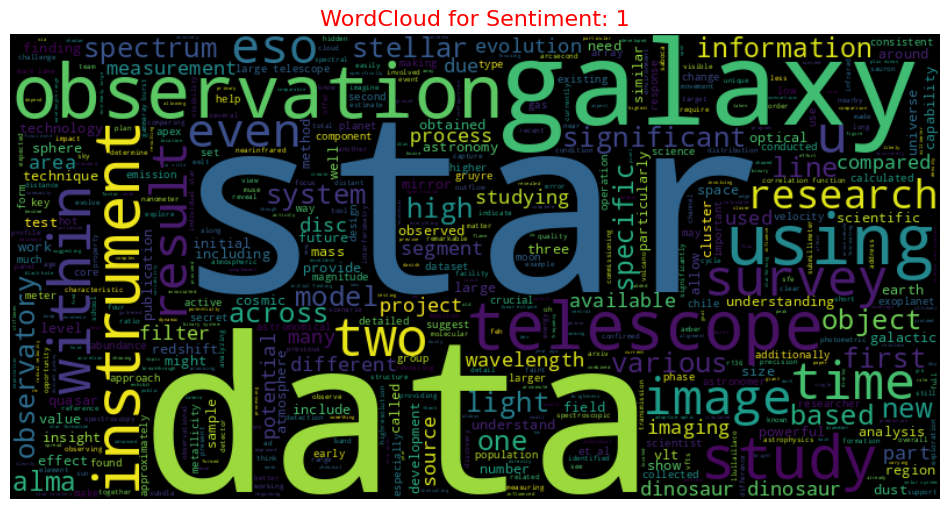

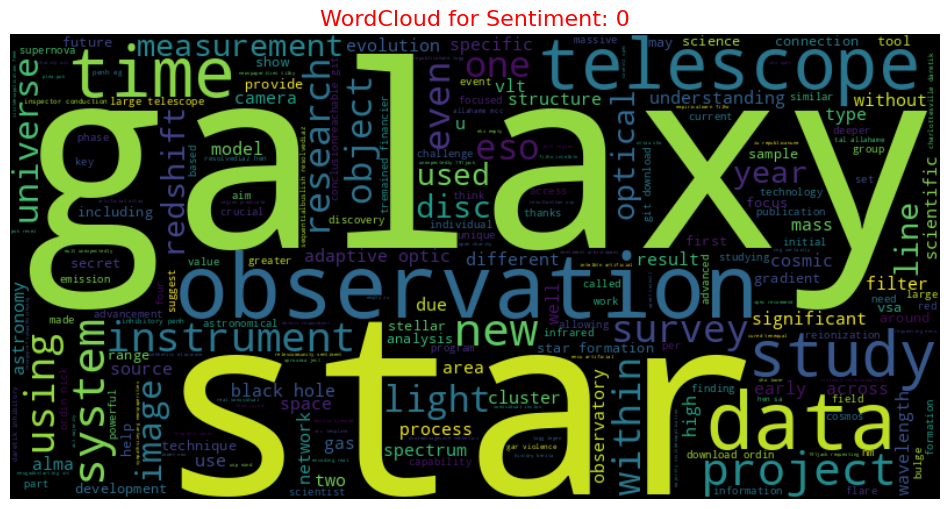

In [ ]:
# WordCloud by Sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud by Sentiment
for sentiment in df['is_file1_real'].unique():
    # Combine text1 and text2 (use cleaned columns if available)
    text = ' '.join(df[df['is_file1_real'] == sentiment]['text1_clean'].astype(str)) + ' ' + \
           ' '.join(df[df['is_file1_real'] == sentiment]['text2_clean'].astype(str))

    wordcloud = WordCloud(
        max_words=500,
        width=800,
        height=400,
        background_color='black'
    ).generate(text)

    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for Sentiment: {sentiment}', color='red', fontsize=16)
    plt.show()

In [ ]:
df.head()

,id,text1,text2,is_file1_real,len_text1,len_text2,wc_text1,wc_text2,similarity,stop_ratio1,stop_ratio2,readability1,ttr_text1,text1_clean,text2_clean
0,0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...,1,2196,2018,304,296,0.189302,0.285714,0.359133,-2.916056,0.819079,virsa visible infrared survey telescope array ...,china relay network released significant amoun...
1,1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...,0,3124,936,454,137,0.188366,0.400786,0.305732,-2.859140,0.709251,china goal project involves achieving accuracy...,project aim achieve accuracy level 005 dex ana...
2,2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...,1,1139,801,159,125,0.060594,0.360465,0.377778,0.219231,0.830189,scientist learn galaxy form evolve two method ...,dinosaur eggshell offer clue dinosaur ate long...
3,3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...,0,1774,1869,263,262,0.125313,0.340694,0.334559,23.320625,0.752852,china study suggests multiple star system play...,importance understanding star evolve led resea...
4,4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...,0,195,871,34,123,0.000000,0.526316,0.278571,68.431667,0.911765,dinosaur rex excited new toy set many dinosaur...,analyzing fast star rotate within galaxy compa...


In [ ]:
df.shape

(95, 15)

## 5. Model Building: BERT

In [ ]:
# ----------------- 1) Imports -----------------
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch

# ----------------- 2) Prepare dataset -----------------
texts1 = list(df['text1_clean'])
texts2 = list(df['text2_clean'])
labels = list(df['is_file1_real'])

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    texts1, texts2, labels, test_size=0.2, random_state=42, stratify=labels
)

ds_train = Dataset.from_dict({'text1': X1_train, 'text2': X2_train, 'label': y_train})
ds_eval  = Dataset.from_dict({'text1': X1_test, 'text2': X2_test, 'label': y_test})

# ----------------- 3) Metric function -----------------
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

# ----------------- 4) Tokenizer and tokenization -----------------
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch['text1'], batch['text2'],
                     truncation=True, padding='max_length', max_length=256)

ds_train_tok = ds_train.map(tokenize_fn, batched=True)
ds_eval_tok  = ds_eval.map(tokenize_fn, batched=True)

# Robust column selection (some tokenizers don't use token_type_ids)
cols = ['input_ids', 'attention_mask', 'label']
if 'token_type_ids' in ds_train_tok.column_names:
    cols = ['input_ids', 'attention_mask', 'token_type_ids', 'label']

ds_train_tok.set_format(type='torch', columns=cols)
ds_eval_tok.set_format(type='torch', columns=cols)

# ----------------- 5) Model -----------------
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ----------------- 6) TrainingArguments with hyperparameter tuning -----------------
common_kwargs = dict(
    output_dir='./bert_pair_out',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs/bert',
    logging_steps=10,
    report_to='none',
    gradient_accumulation_steps=2,
    warmup_ratio=0.1
)

try:
    training_args = TrainingArguments(
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
        **common_kwargs
    )
except TypeError:
    training_args = TrainingArguments(
        save_strategy='epoch',
        do_eval=True,
        **common_kwargs
    )

# ----------------- 7) Trainer -----------------
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=ds_train_tok.shuffle(seed=42),  # shuffle at start
    eval_dataset=ds_eval_tok,
    compute_metrics=compute_metrics,
    #label_smoothing_factor=0.1
)

# ----------------- 8) Train -----------------
trainer.train()

# ----------------- 9) Evaluate -----------------
eval_res = trainer.evaluate()
preds = np.argmax(trainer.predict(ds_eval_tok).predictions, axis=1)

print("\n=== BERT Pair Evaluation ===")
print("Accuracy:", eval_res.get('eval_accuracy', eval_res.get('accuracy', None)))
print("Classification Report:\n", classification_report(y_test, preds, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

# ----------------- 10) Save trained model -----------------
# Save model + tokenizer
trainer.save_model('./bert_pair_out_best')   # saves model
tokenizer.save_pretrained('./bert_pair_out_best')  # explicitly save tokenizer

pairwise_correct = np.sum(preds == y_test)
pairwise_acc = pairwise_correct / len(y_test)
print("Pairwise Accuracy:", pairwise_acc)

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.701500
20,0.705000
30,0.720000
40,0.639900
50,0.554200
60,0.200000
70,0.028700
80,0.002100
90,0.000900
100,0.000600



=== BERT Pair Evaluation ===
Accuracy: 0.9473684210526315
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.89      0.94         9

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19

Confusion Matrix:
 [[10  0]
 [ 1  8]]
Pairwise Accuracy: 0.9473684210526315


## 6. Predicting on test data

In [ ]:
df_test.head()

,id,text1,text2,text1_clean,text2_clean
0,0,"""Music"" Music music music Music music Music mu...",Since its launch on Paranal observatory's Very...,music music music music music music music musi...,since launch paranal observatory large telesco...
1,1,underground exploration on SN's birth has prov...,SN 1987A provides valuable insights as newer o...,underground exploration sn birth provided valu...,sn 1987a provides valuable insight newer obser...
2,2,This research aimed to understand how star sha...,ChromeDriver music player\nThis study focused ...,research aimed understand star shape differ pe...,chromedriver music player study focused identi...
3,3,Using OmegaCAM's wide field capabilities spann...,"greek translation :\nvazhi (megaCAM), territor...",using omegacams wide field capability spanning...,greek translation vazhi megacam territorias me...
4,4,AssemblyCulture AssemblyCulture AssemblyCultur...,XClass is software tool that helps astronomers...,assemblyculture assemblyculture assemblycultur...,xclass software tool help astronomer analyze a...


In [ ]:
# Drop or fill missing text rows
df_test = df_test.dropna(subset=['text1_clean', 'text2_clean']).reset_index(drop=True)

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ----------------- 6) Load saved model & tokenizer -----------------
model_path = '/content/bert_pair_out_best'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_bert = AutoModelForSequenceClassification.from_pretrained(model_path)
model_bert.eval()  # evaluation mode

# ----------------- 7) Batch-wise prediction to save RAM -----------------
batch_size = 16
preds_all = []

for i in range(0, len(df_test), batch_size):
    batch_text1 = df_test['text1_clean'].iloc[i:i+batch_size].tolist()
    batch_text2 = df_test['text2_clean'].iloc[i:i+batch_size].tolist()

    inputs = tokenizer(batch_text1, batch_text2,
                       truncation=True,
                       padding='max_length',
                       max_length=256,
                       return_tensors='pt')

    with torch.no_grad():
        outputs = model_bert(**inputs)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        preds_all.extend(batch_preds)

# ----------------- 8) Map predictions to 1 or 2 -----------------
# Safety check
assert len(preds_all) == len(df_test), f"Mismatch: preds={len(preds_all)}, rows={len(df_test)}"
# 1 => text1 real, 2 => text2 real
df_test['predicted_label'] = [1 if p==1 else 2 for p in preds_all]

# ----------------- 9) Save results -----------------
submission = df_test[['id', 'predicted_label']].copy()

# Save final file
submission.to_csv('df_test_cls.csv', index=False, encoding='utf-8-sig')
print("Predictions saved to df_test_cls.csv ")

Predictions saved to df_test_cls.csv
